In [1]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

C:\Users\marou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("D:/ETUDES/Formation/Projet ML/Credit home/train.csv")
test_df = pd.read_csv("D:/ETUDES/Formation/Projet ML/Credit home/test.csv")

In [3]:
# 2. Data Engineering - Adding new features
train_df['TotalIncome'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']
train_df['MonthlyPayment'] = train_df['LoanAmount']*1000 / train_df['Loan_Amount_Term']/12
train_df['ResidualIncome'] = train_df['TotalIncome'] - train_df['MonthlyPayment']

In [4]:
test_df['TotalIncome'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']
test_df['MonthlyPayment'] = test_df['LoanAmount']*1000 / test_df['Loan_Amount_Term']/12
test_df['ResidualIncome'] = test_df['TotalIncome'] - test_df['MonthlyPayment']

In [5]:
train_df = train_df.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])
test_df = test_df.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

In [6]:
# 3. Outlier Detection and Handling
def plot_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

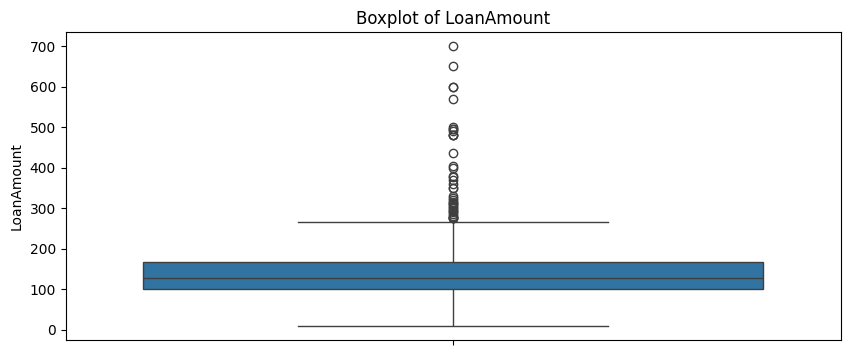

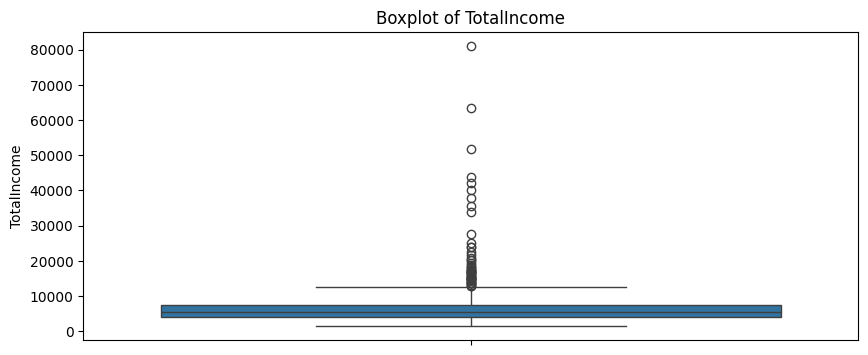

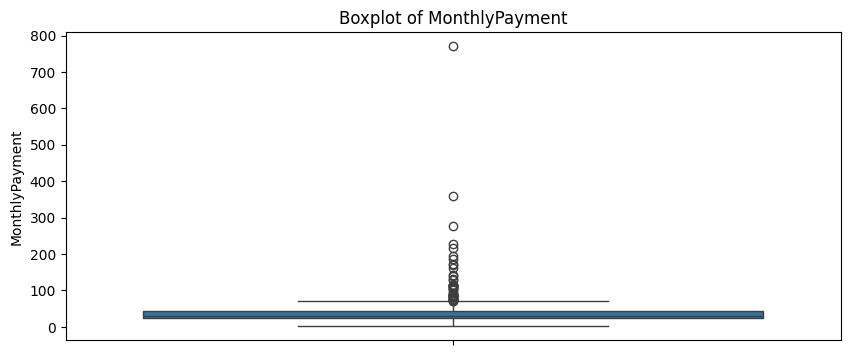

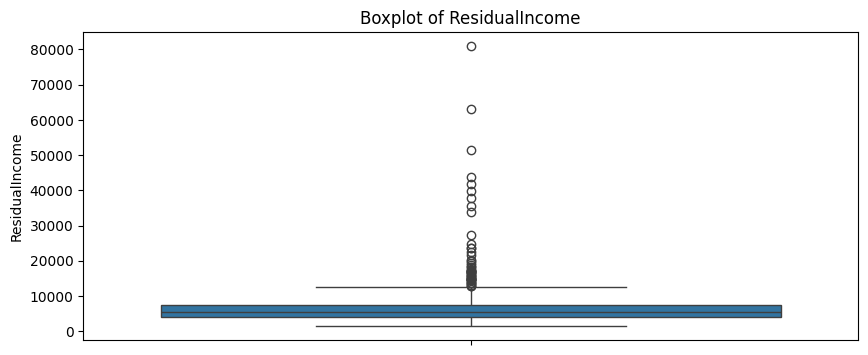

In [7]:
numerical_columns = ['LoanAmount', 'TotalIncome', 'MonthlyPayment','ResidualIncome']
plot_outliers(train_df, numerical_columns)

In [8]:
# Handling outliers - Capping them to the 99th percentile
for col in numerical_columns:
    upper_limit = train_df[col].quantile(0.99)
    train_df[col] = np.where(train_df[col] > upper_limit, upper_limit, train_df[col])

In [9]:
train_df.describe()

,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,MonthlyPayment,ResidualIncome
count,592.000000,600.00000,564.000000,614.000000,578.000000,578.000000
mean,145.327973,342.00000,0.842199,6865.703681,38.433132,6876.093790
std,80.051564,65.12041,0.364878,5230.964958,28.030692,5357.353892
min,9.000000,12.00000,0.000000,1442.000000,2.083333,1433.898148
25%,100.000000,360.00000,1.000000,4166.000000,23.842593,4135.912037
50%,128.000000,360.00000,1.000000,5416.500000,30.439815,5369.884259
75%,168.000000,360.00000,1.000000,7521.750000,42.824074,7489.187500
max,496.360000,480.00000,1.000000,37453.020000,187.314815,38152.418519


In [10]:
# 4. Preprocessing (Handling Missing Values, Encoding, and Scaling)
# Define categorical and numerical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_cols = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 
                  'TotalIncome', 'MonthlyPayment', 'ResidualIncome']

In [11]:
# Remplace LabelEncoder par OrdinalEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())  # Utilisation d'OrdinalEncoder
])

In [12]:
# Define preprocessing for numerical data (impute missing values, then scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [13]:
# Combine both numerical and categorical transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [14]:
# 5. Feature Selection
# Separate target variable and features
X = train_df.drop(columns=['Loan_ID', 'Loan_Status'])
y = train_df['Loan_Status']

In [15]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Build a pipeline that combines preprocessing and the model
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', LogisticRegression(random_state=42))
])

In [17]:
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History',
                                                   'TotalIncome',
                                                   'MonthlyPayment',
                                                   'ResidualIncome']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [18]:
# Feature importance using Random Forest
model = model_pipeline.named_steps['classifier']
# feature_importances = model.feature_importances_

In [19]:
# Show feature importance
#important_features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
#important_features = important_features.sort_values(by='Importance', ascending=False)
#print("Feature Importance:\n", important_features)

In [20]:
# 6. Final Model - Re-training using selected important features
#selected_features = important_features[important_features['Importance'] > 0.01]['Feature'].tolist()
#X_train_selected = X_train[selected_features]
#X_val_selected = X_val[selected_features]

In [21]:
#selected_features

In [22]:
# Train again with the selected features
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History',
                                                   'TotalIncome',
                                                   'MonthlyPayment',
                                                   'ResidualIncome']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_Area'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [23]:
# Predict on validation set
y_pred = model_pipeline.predict(X_val)

In [24]:
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

In [25]:
print("Validation Accuracy: ", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Validation Accuracy:  0.7723577235772358

Confusion Matrix:
 [[22 21]
 [ 7 73]]

Classification Report:
               precision    recall  f1-score   support

           N       0.76      0.51      0.61        43
           Y       0.78      0.91      0.84        80

    accuracy                           0.77       123
   macro avg       0.77      0.71      0.73       123
weighted avg       0.77      0.77      0.76       123



In [26]:
X_test = test_df
test_predictions = model_pipeline.predict(X_test)

In [27]:
output = pd.DataFrame({'Loan_ID': test_df['Loan_ID'], 'Loan_Status': test_predictions})

In [28]:
output

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,N
365,LP002986,Y


In [29]:
output['Loan_Status'].value_counts()

Loan_Status
Y    274
N     93
Name: count, dtype: int64

In [30]:
pd.crosstab(output['Loan_ID'], output['Loan_Status'])

Loan_Status,N,Y
Loan_ID,,
LP001015,0,1
LP001022,0,1
LP001031,0,1
LP001035,0,1
LP001051,0,1
...,...,...
LP002971,0,1
LP002975,0,1
LP002980,1,0


In [31]:
import joblib

# Sauvegarder le pipeline de prétraitement et de modèle
joblib.dump(model_pipeline, 'loan_approval_model.pkl')


['loan_approval_model.pkl']

In [32]:
# Charger le modèle sauvegardé
model = joblib.load('loan_approval_model.pkl')

# Fonction pour faire des prédictions
def predict_loan_status(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area):
    
    # Créer un DataFrame avec les données entrées par l'utilisateur
    input_data = pd.DataFrame({
        'Gender': [Gender],
        'Married': [Married],
        'Dependents': [Dependents],
        'Education': [Education],
        'Self_Employed': [Self_Employed],
        'ApplicantIncome': [ApplicantIncome],
        'CoapplicantIncome': [CoapplicantIncome],
        'LoanAmount': [LoanAmount],
        'Loan_Amount_Term': [Loan_Amount_Term],
        'Credit_History': [Credit_History],
        'Property_Area': [Property_Area]
    })
      # Générer les nouvelles colonnes attendues par le modèle
    input_data['TotalIncome'] = input_data['ApplicantIncome'] + input_data['CoapplicantIncome']
    input_data['MonthlyPayment'] = input_data['LoanAmount']*1000 / input_data['Loan_Amount_Term']/12
    input_data['ResidualIncome'] = input_data['TotalIncome'] - input_data['MonthlyPayment']
    # Prédire avec le modèle chargé
    prediction = model.predict(input_data)[0]
    
    # Retourner le résultat de la prédiction
    return "Loan Approved" if prediction == 'Y' else "Loan Rejected"


In [33]:
interface = gr.Interface(
    fn=predict_loan_status,  # La fonction de prédiction
    inputs=[
        gr.Dropdown(['Male', 'Female'], label='Gender'),
        gr.Radio(['Yes', 'No'], label='Married'),
        gr.Dropdown(['0', '1', '2', '3+'], label='Dependents'),
        gr.Radio(['Graduate', 'Not Graduate'], label='Education'),
        gr.Radio(['Yes', 'No'], label='Self Employed'),
        gr.Slider(100, 50000, label='Applicant Income'),
        gr.Slider(0, 30000, label='Coapplicant Income'),
        gr.Slider(50, 1000, label='Loan Amount'),
        gr.Slider(12, 480, label='Loan Amount Term'),
        gr.Radio([1.0, 0.0], label='Credit History'),
        gr.Radio(['Urban', 'Rural', 'Semiurban'], label='Property Area')
    ],
    outputs=gr.Textbox(label="Loan Status"),  # Le résultat de la prédiction
    title="Loan Approval Prediction",
    description="Entrez les informations ci-dessus pour prédire si le prêt sera approuvé ou non."
)

# Lancer l'interface
interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
